In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_all_fills():
    prefix = "../data/fill_data/"
    dfs = []
    for fname in os.listdir(prefix):
        # print(fname)
        dfs.append(pd.read_json(f"{prefix}{fname}"))
    
    df = pd.concat(dfs).set_index("fill_id")

    df["size"] = df["side"].apply(lambda x: 1 if x=="BUY" else -1) * df["size"]
    df["fill_volume"] = df["price"] * (df["size"].abs())
    return df

all_fills = get_all_fills()
all_fills

,side,liquidity,fee,market,price,size,fill_height,fill_ts,fill_volume
fill_id,,,,,,,,,
2e292041-7956-5fdc-8c08-d0e29205b698,SELL,MAKER,0.099678,TLOS-USD,0.19280,-5170.0,19905284,1720410443695,996.776
2db5faab-fe08-5792-8d1f-ac396e26b547,SELL,MAKER,0.099597,TLOS-USD,0.19190,-5190.0,19905639,1720410871524,995.961
cfbb9bf6-f71a-5ff5-b8a2-6cbe72bf54f0,SELL,MAKER,0.099648,TLOS-USD,0.19200,-5190.0,19905640,1720410872544,996.480
cf37dde4-61c8-5b5b-9839-23a3b27569cb,BUY,MAKER,0.099807,TLOS-USD,0.19120,5220.0,19906771,1720412240465,998.064
749e0768-1526-5d66-bd8d-e56c64950ec4,BUY,MAKER,0.099875,TLOS-USD,0.19060,5240.0,19906839,1720412327317,998.744
...,...,...,...,...,...,...,...,...,...
3c16ee94-ba1b-57a7-b61f-94f67b7b231c,SELL,MAKER,-0.000247,JASMY-USD,0.02248,-100.0,30489533,1731961564703,2.248
5a07bc0c-8f2b-527f-b8d0-ba0f37d9208a,BUY,MAKER,-0.000483,JASMY-USD,0.02198,200.0,30502733,1731974735196,4.396
a85d892a-497a-55fd-939e-f8c1419ba7cf,SELL,MAKER,-0.000246,JASMY-USD,0.02245,-100.0,30512175,1731984605677,2.245


In [2]:
# Basic overall data
num_fills = len(set(all_fills.index.values))
assert num_fills == len(all_fills), "Non-unique fill id present."

print(f"Our fist fill was at timestamp {all_fills['fill_ts'].min()}.")
print(f"We allocated to {all_fills['market'].nunique()} markets total.")
print(f"There were {num_fills:,} fills across all vaults.")

Our fist fill was at timestamp 1717831684330.
We allocated to 117 markets total.
There were 492,894 fills across all vaults.


In [3]:
# Volume

total_fill_volume = all_fills["fill_volume"].sum()
maker_volume = all_fills[all_fills["liquidity"]=="MAKER"]["fill_volume"].sum()
taker_volume = all_fills[all_fills["liquidity"]=="TAKER"]["fill_volume"].sum()


print(f"Total volume:\t${total_fill_volume:,.2f}")
print(f"Maker:\t\t${maker_volume:,.2f}")
print(f"Taker:\t\t${taker_volume:,.2f}")

Total volume:	$332,346,286.23
Maker:		$316,246,185.14
Taker:		$16,100,101.08


In [4]:
# Fees

total_net_fees = all_fills["fee"].sum()
maker_fees = all_fills[all_fills["liquidity"]=="MAKER"]["fee"].sum()
taker_fees = all_fills[all_fills["liquidity"]=="TAKER"]["fee"].sum()


print(f"Total net fees:\t${total_net_fees:,.2f}")
print(f"Maker:\t\t${maker_fees:,.2f}")
print(f"Taker:\t\t${taker_fees:,.2f}")

Total net fees:	$-27,838.33
Maker:		$-32,687.99
Taker:		$4,849.66


In [8]:
# Funding payments
def get_total_funding_each_market():
    prefix = "../data/funding_data/"
    dfs = []
    for fname in os.listdir(prefix):
        print(fname)
        dfs.append(pd.read_json(f"{prefix}{fname}"))
    
    df = pd.concat(dfs).set_index("pxn_ts")

    return df.groupby("vault_market")["pxn_total_funding"].sum()

per_market_fundings = get_total_funding_each_market()

TLOS-USD.json
SUSHI-USD.json
BLAST-USD.json
VRTX-USD.json
PENDLE-USD.json
ZK-USD.json
NOT-USD.json
INJ-USD.json
ZERO-USD.json
SEI-USD.json
WIF-USD.json
ASTR-USD.json
ALGO-USD.json
TRY-USD.json
TRX-USD.json
RETARDIO-USD.json
APT-USD.json
MEW-USD.json
CORE-USD.json
OSMO-USD.json
DAI-USD.json
MAVIA-USD.json
SATS-USD.json
XTZ-USD.json
CVX-USD.json
PAXG-USD.json
AEVO-USD.json
PRIME-USD.json
BRETT-USD.json
STX-USD.json
WLD-USD.json
POPCAT-USD.json
HBAR-USD.json
ORDI-USD.json
DMAIL-USD.json
MANA-USD.json
BODEN-USD.json
OM-USD.json
BNB-USD.json
TREMP-USD.json
MOTHER-USD.json
PYTH-USD.json
XAI-USD.json
GRT-USD.json
GMX-USD.json
EGLD-USD.json
TON-USD.json
BEAM-USD.json
ONDO-USD.json
ZRO-USD.json
STRK-USD.json
AR-USD.json
KAS-USD.json
CAKE-USD.json
AXL-USD.json
BLUR-USD.json
IMX-USD.json
UMA-USD.json
HNT-USD.json
WOO-USD.json
TIA-USD.json
EURC-USD.json
NEO-USD.json
ALT-USD.json
ETH-USD.json
FLOKI-USD.json
FTM-USD.json
JTO-USD.json
TAO-USD.json
TRUMPWIN-USD.json
MNT-USD.json
W-USD.json
ENA-USD.jso

In [9]:
# Per-market stats
per_market_grp = all_fills.groupby("market")
per_market_stats = {}

# per-market num fills
per_market_stats["n_fills"] = per_market_grp["fill_volume"].size()

# per-market volumes
per_market_stats["total_volume"] = per_market_grp["fill_volume"].sum()
per_market_stats["maker_volume"] = all_fills[all_fills["liquidity"]=="MAKER"].groupby("market")["fill_volume"].sum()
per_market_stats["taker_volume"] = all_fills[all_fills["liquidity"]=="TAKER"].groupby("market")["fill_volume"].sum()

# per-market most recent fill price
most_recent_fill_time_each_mkt = per_market_grp["fill_ts"].max()
per_market_stats["most_recent_price"] = all_fills[all_fills.apply(
    lambda row: row["fill_ts"] == most_recent_fill_time_each_mkt[row["market"]],
    axis=1
)].groupby("market").apply(lambda x: x.iloc[0])["price"]

# per-market edge metrics
per_market_stats["net_funding"] = per_market_fundings
per_market_stats["net_ending_pxn"] = per_market_grp["size"].sum()
per_market_stats["net_sell_volume_usd"] = (
    all_fills[all_fills["side"]=="SELL"].groupby("market")["fill_volume"].sum()
    - all_fills[all_fills["side"]=="BUY"].groupby("market")["fill_volume"].sum()
)
per_market_stats["approx_pre_fee_pnl_usd"] = per_market_stats["net_sell_volume_usd"] + (per_market_stats["net_ending_pxn"]*per_market_stats["most_recent_price"]) + per_market_stats["net_funding"]
per_market_stats["net_fees_usd"] = per_market_grp["fee"].sum()
per_market_stats["approx_post_fee_pnl_usd"] = per_market_stats["approx_pre_fee_pnl_usd"] - per_market_stats["net_fees_usd"]
per_market_stats["approx_post_fee_edge_bps"] = 10_000.0 * (per_market_stats["approx_post_fee_pnl_usd"] / per_market_stats["total_volume"])

# computing cost of liquidity for the uptime
per_market_stats["quoting_duration_months"] = (
    per_market_grp["fill_ts"].max()
    - per_market_grp["fill_ts"].min()
) / (1_000.0 * 60 * 60 * 24 * 30.42)
per_market_stats["cost_of_liquidity_monthly_usd"] = (-per_market_stats["approx_post_fee_pnl_usd"]) / per_market_stats["quoting_duration_months"]


per_market_stats = pd.DataFrame(per_market_stats)
per_market_stats

/var/folders/my/vd0mq5wd641g3ntydbr628180000gn/T/ipykernel_75115/2698215881.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  )].groupby("market").apply(lambda x: x.iloc[0])["price"]


,n_fills,total_volume,maker_volume,taker_volume,most_recent_price,net_funding,net_ending_pxn,net_sell_volume_usd,approx_pre_fee_pnl_usd,net_fees_usd,approx_post_fee_pnl_usd,approx_post_fee_edge_bps,quoting_duration_months,cost_of_liquidity_monthly_usd
1INCH-USD,3118,1.978275e+06,1958275.872,19998.749000,0.362000,3.440723,-360.0,-401.741000,-528.620277,-200.472351,-328.147926,-1.658758,4.121401,79.620485
AEVO-USD,1129,7.329493e+05,715349.535,17599.774000,0.357000,0.005176,-5233.0,1956.077000,87.901176,-74.287977,162.189153,2.212829,2.991894,-54.209521
AKT-USD,2023,1.631354e+06,1494837.709,136516.258000,4.109000,1094.060510,-589.0,1481.829000,155.688510,135.678739,20.009771,0.122657,4.430073,-4.516804
ALGO-USD,12086,8.226654e+06,7872498.759,354154.928000,0.218900,2.735298,-16960.0,-4014.187000,-7723.995702,-777.318486,-6946.677216,-8.444110,3.207646,2165.661899
ALT-USD,56,3.043867e+04,17689.851,12748.815000,0.111100,0.043436,-500.0,-337.134000,-392.640564,1.247663,-393.888227,-129.403906,3.059969,128.722966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEN-USD,41,2.465661e+03,2465.661,NaN,9.225000,0.000000,-18.0,178.603000,12.553000,-0.245672,12.798672,51.907671,2.910431,-4.397518
ZERO-USD,170,6.689910e+04,25383.290,41515.805666,0.000342,818.568153,-50000.0,-10839.373666,-10037.880513,-1.038378,-10036.842135,-1500.295637,2.587525,3878.934589
ZK-USD,1632,9.795997e+05,965689.575,13910.150000,0.141600,0.120895,6080.0,-1153.153000,-292.104105,-102.747563,-189.356542,-1.932999,3.002116,63.074349
ZRO-USD,2965,1.494463e+06,1483578.722,10883.990000,3.518000,0.327404,253.0,-2577.468000,-1687.086596,-160.358043,-1526.728553,-10.215903,2.805909,544.111903


In [10]:
per_market_stats.loc[["BTC-USD", "ETH-USD"]]

,n_fills,total_volume,maker_volume,taker_volume,most_recent_price,net_funding,net_ending_pxn,net_sell_volume_usd,approx_pre_fee_pnl_usd,net_fees_usd,approx_post_fee_pnl_usd,approx_post_fee_edge_bps,quoting_duration_months,cost_of_liquidity_monthly_usd
BTC-USD,3191,3.086212e+06,2.823880e+06,262332.4908,91941.0,37.269045,-0.2468,23867.6379,1213.868145,-240.416848,1454.284993,4.712200,2.215373,-656.451474
ETH-USD,497,3.849405e+05,3.379578e+05,46982.7514,3094.2,10.506432,-0.4690,2257.7762,817.102832,-25.314002,842.416834,21.884338,2.191408,-384.418020


## PnL

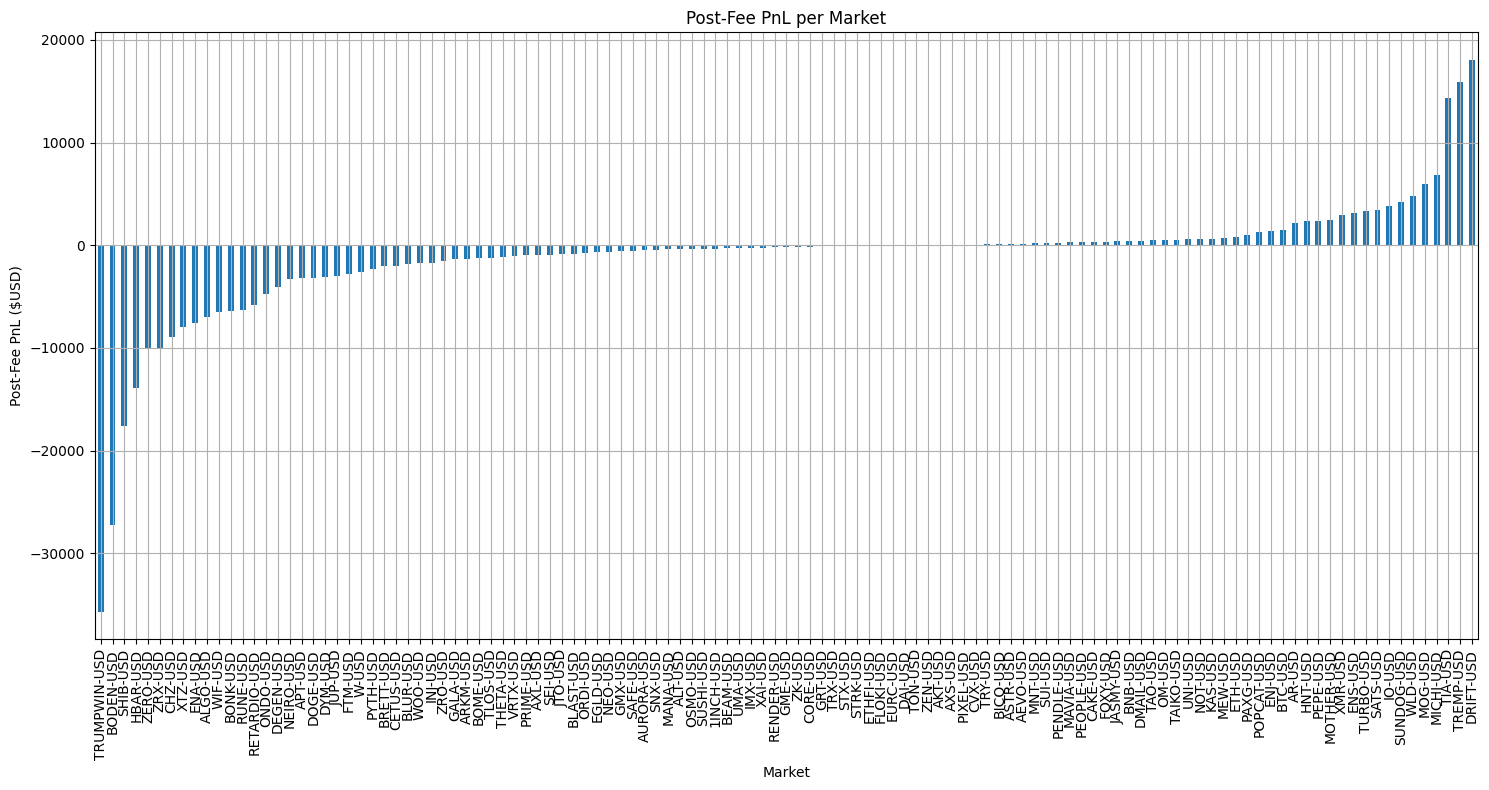

In [11]:
plt.figure(figsize=(15, 8))  # Adjust the size as needed
per_market_stats["approx_post_fee_pnl_usd"].sort_values(ascending=True).plot(
    kind="bar",
    title="Post-Fee PnL per Market",
    fontsize=10,
    xlabel="Market",
    ylabel="Post-Fee PnL ($USD)",
    grid=True,
)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show();

In [12]:
# aggregated pnl across all markets
total_pre_fee_pnl = per_market_stats["approx_pre_fee_pnl_usd"].sum()
total_post_fee_pnl = total_pre_fee_pnl - total_net_fees
portfolio_edge_bps = total_post_fee_pnl / total_fill_volume * 10_000.0


print(f"Total vault Pre-Fee PnL: ${total_pre_fee_pnl:,.2f}")
print(f"Total vault Post-Fee PnL: ${total_post_fee_pnl:,.2f}")
print(f"Total vault Post-Fee Edge (bps): {portfolio_edge_bps:,.2f}")

Total vault Pre-Fee PnL: $-152,514.68
Total vault Post-Fee PnL: $-124,676.35
Total vault Post-Fee Edge (bps): -3.75


## Cost of Liquidity

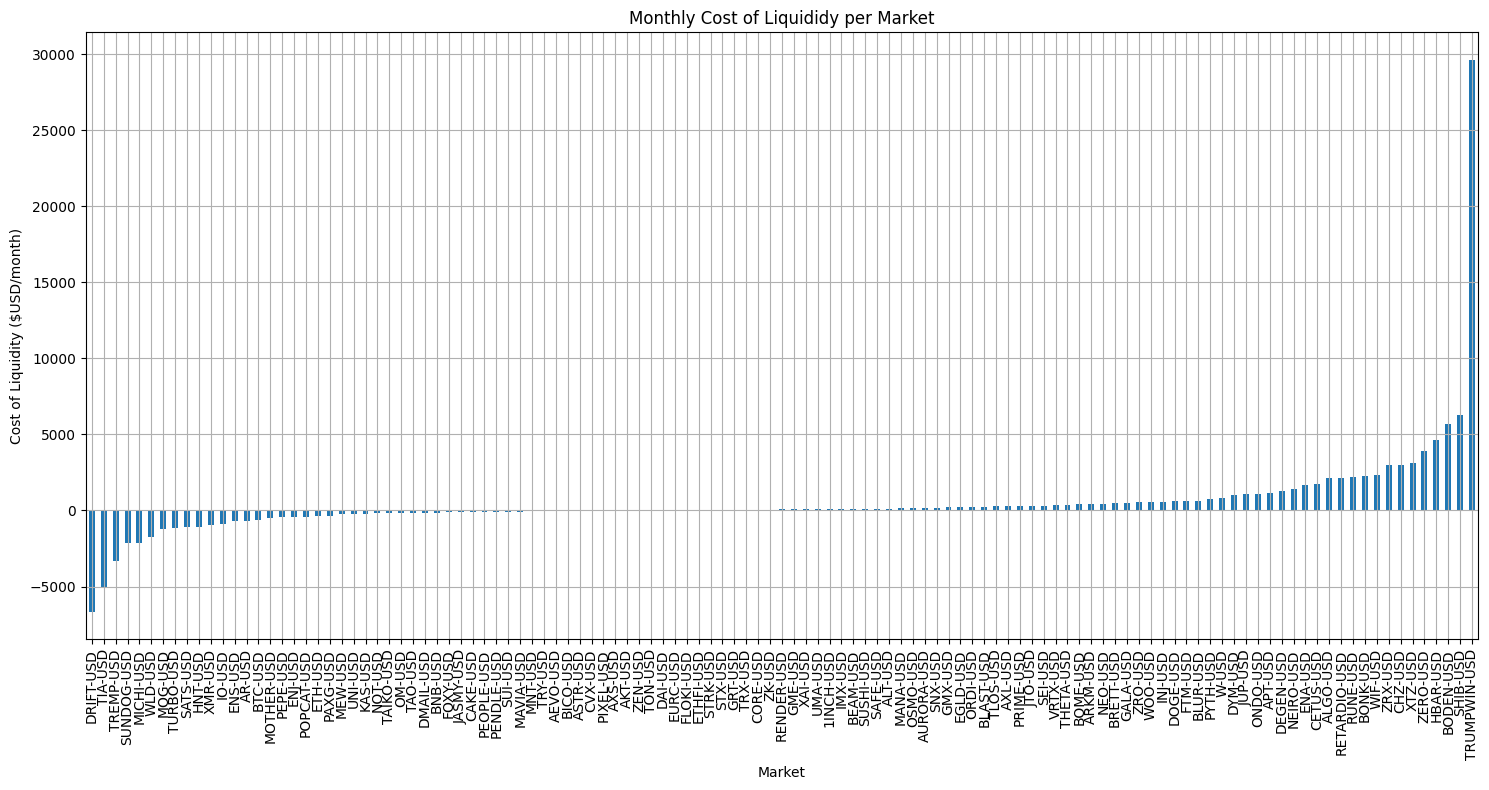

In [13]:
# Per-Market Cost of Liquidity
plt.figure(figsize=(15, 8))  # Adjust the size as needed
per_market_stats["cost_of_liquidity_monthly_usd"].sort_values(ascending=True).plot(
    kind="bar",
    title="Monthly Cost of Liquididy per Market",
    fontsize=10,
    xlabel="Market",
    ylabel="Cost of Liquidity ($USD/month)",
    grid=True,
)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show();

In [14]:
# Aggregated Cost of Liquidity
liq_cost_total = per_market_stats["cost_of_liquidity_monthly_usd"].sum()
liq_cost_avg = per_market_stats["cost_of_liquidity_monthly_usd"].mean()
liq_cost_stdev = per_market_stats["cost_of_liquidity_monthly_usd"].std()
# liq_cost_mean_stdev = liq_cost_stdev / np.sqrt(len(per_market_stats))


print(f"Total cost of liquidity across markets:\t\t${liq_cost_total:,.2f} / month")
print(f"Avg. cost of liquidity across markets:\t\t${liq_cost_avg:,.2f} / month")
print(f"Stdev cost of liquidity across markets:\t\t${liq_cost_stdev:,.2f} / month")
print(f"Stdev of total monthly cost of liquidity:\t${liq_cost_stdev*np.sqrt(len(per_market_stats)):,.2f} / month")

print()
print(f"Ann. exp. total cost of liquidity:\t\t${liq_cost_total*12:,.2f} / year")
print(f"Stdev of total annual cost of liquidity:\t${liq_cost_stdev*np.sqrt(len(per_market_stats))*np.sqrt(12):,.2f} / year")
print(f"3σ annual cost of liquidity:\t\t\t${liq_cost_total*12 + 3*liq_cost_stdev*np.sqrt(len(per_market_stats))*np.sqrt(12):,.2f} / year")

Total cost of liquidity across markets:		$58,549.97 / month
Avg. cost of liquidity across markets:		$500.43 / month
Stdev cost of liquidity across markets:		$3,123.95 / month
Stdev of total monthly cost of liquidity:	$33,790.71 / month

Ann. exp. total cost of liquidity:		$702,599.61 / year
Stdev of total annual cost of liquidity:	$117,054.45 / year
3σ annual cost of liquidity:			$1,053,762.96 / year


## Deposits

In [15]:
def get_all_transfers():
    prefix = "../data/transfer_data/"
    dfs = []
    for fname in os.listdir(prefix):
        # print(fname)
        dfs.append(pd.read_json(f"{prefix}{fname}"))
    
    df = pd.concat(dfs).set_index("transfer_id")

    return df

all_transfers = get_all_transfers()
all_transfers

,vault_market,asset,type,amount,tx_hash,transfer_height,transfer_ts
transfer_id,,,,,,,
2b324733-ef7f-5184-bb56-3896dcf1f021,TLOS-USD,USDC,TRANSFER_IN,0.000001,0C704F81EF5FD6540AEBF23104612F65E444128F882287...,19903969,1720430426119
a009d7f0-a3db-5322-81f9-1ed4aa67e9a9,SUSHI-USD,USDC,TRANSFER_IN,10000.000000,219B31D78FE1AED2F7CC3ECBC4E170D852CA3D181CB77E...,22873426,1723742756487
94aec4d4-19a6-58fb-b5e6-1553f09357f3,BLAST-USD,USDC,TRANSFER_IN,10000.000000,91A2015145B354505DABCA1D5CAAFF4FB1C8CB51D2A3FB...,22873472,1723742810947
7a745bff-b2d8-58f5-be39-c463d2e46a88,VRTX-USD,USDC,TRANSFER_IN,10000.000000,A2A8A74A288EF6259A24921E2B3562AFBDE9A17E5806F7...,22874116,1723743575512
5a75b853-bd9a-5f30-87c7-1a00dcf532f1,PENDLE-USD,USDC,TRANSFER_IN,10000.000000,00182E5E9E2B6FA1BB50E84EF4C61E324EFF57C179A835...,23739573,1724703199600
...,...,...,...,...,...,...,...
fce4bf8b-1e4a-5a6a-86bc-74486d809aef,THETA-USD,USDC,TRANSFER_IN,10000.000000,7B81213935060B3A5DBB4A27A3703806D33D344D7E0AA4...,22237372,1723062481629
3a3c4b18-aa9d-5645-8b7a-0d327655aec3,GME-USD,USDC,TRANSFER_IN,10000.000000,674AD6F068C84133A0CABFE1DEA5ABD10F6F65D6BB47FC...,23739977,1724703658474
9c687d01-d754-581d-95f6-b75c1dc7536b,IO-USD,USDC,TRANSFER_IN,0.000001,0D12A05C0C471AE75982F183041AFD85AC27BDE762A473...,19904085,1720430567865


In [16]:
all_deposits = all_transfers[all_transfers["type"]=="TRANSFER_IN"]
per_market_deposits = all_deposits.groupby("vault_market")["amount"].sum().sort_values()
per_market_deposits

vault_market
FTM-USD              0.000001
SAFE-USD             0.000001
ENA-USD              0.000001
ENS-USD              0.000001
BRETT-USD            0.000001
                    ...      
BONK-USD         30000.000000
SHIB-USD         30000.000000
MICHI-USD        40000.000000
TRY-USD          50000.000000
TRUMPWIN-USD    100000.000000
Name: amount, Length: 118, dtype: float64

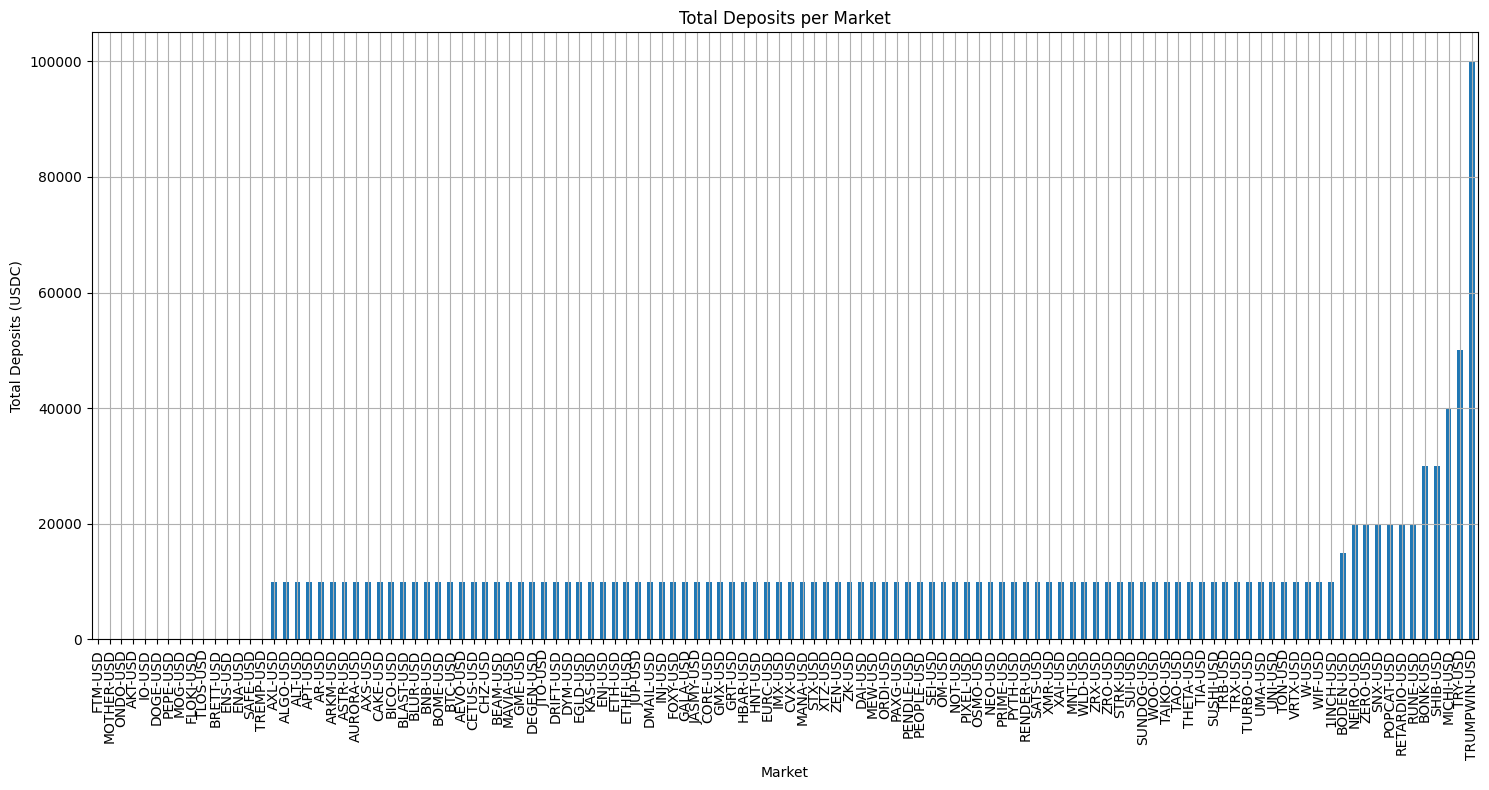

In [17]:
plt.figure(figsize=(15, 8))  # Adjust the size as needed
per_market_deposits.sort_values(ascending=True).plot(
    kind="bar",
    title="Total Deposits per Market",
    fontsize=10,
    xlabel="Market",
    ylabel="Total Deposits (USDC)",
    grid=True,
)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show();

## Funding Rates

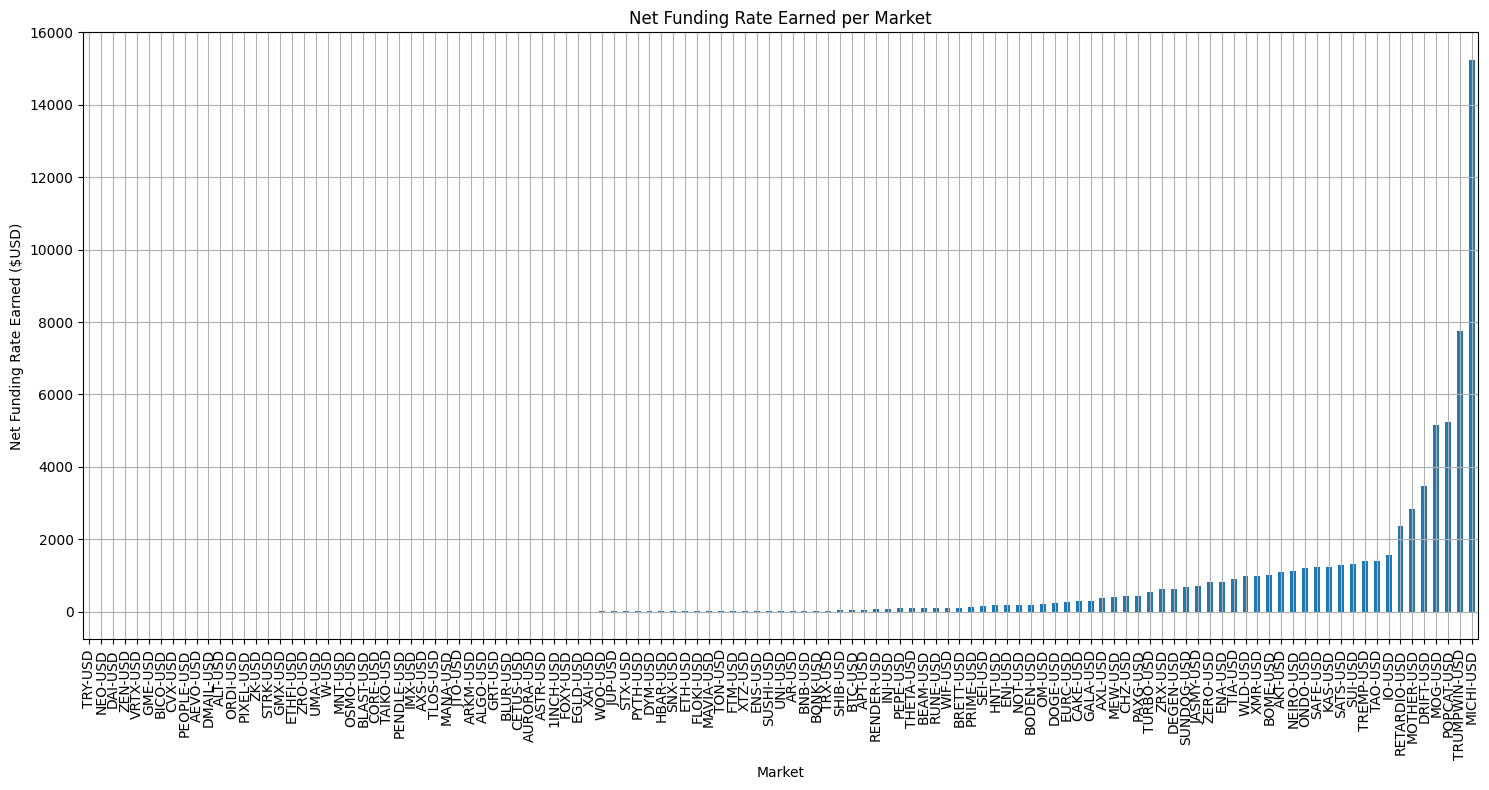

In [18]:
plt.figure(figsize=(15, 8))  # Adjust the size as needed
per_market_fundings.sort_values(ascending=True).plot(
    kind="bar",
    title="Net Funding Rate Earned per Market",
    fontsize=10,
    xlabel="Market",
    ylabel="Net Funding Rate Earned ($USD)",
    grid=True,
)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show();